In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import pickle
import matplotlib.pyplot as plt
import os

Set paths, import data:

In [2]:
path_data = "C:/Users/SG/hlca_core.h5ad"
path_results = "Exploration_results/"

In [3]:
adata = anndata.read_h5ad(path_data, backed = 'r')

if not os.path.exists(path_results):
    os.makedirs(path_results)

### UMAPs

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


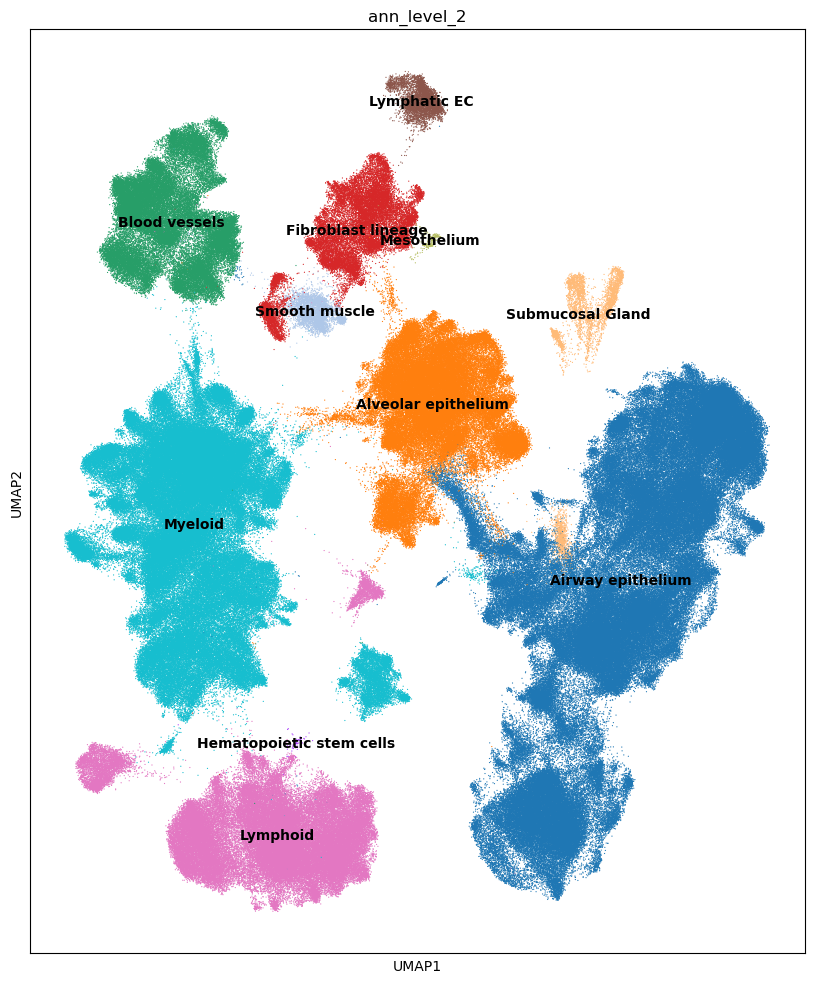

In [4]:
# cell type (ann_2)
plt.rcParams["figure.figsize"] = [10,12]

sc.pl.umap(adata, color="ann_level_2", legend_loc="on data", legend_fontsize=10, size=3)
plt.show()

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


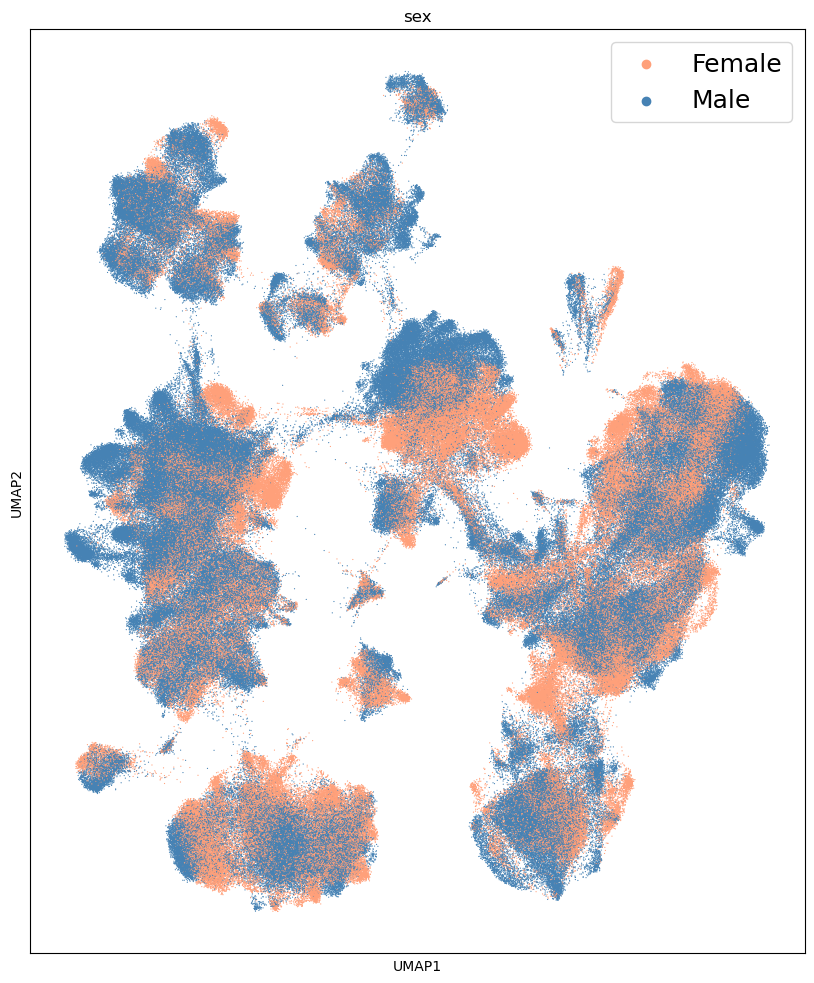

In [5]:
# sex
sex_color_map = {'male': 'steelblue', 'female': 'lightsalmon'}

sc.pl.umap(adata, color="sex", size=3, palette=sex_color_map, show = False)

legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 1), framealpha = 0.8, fontsize=18)
legend = plt.gca().get_legend()
for text in legend.get_texts():
    if text.get_text() == 'male':
        text.set_text('Male')
    elif text.get_text() == 'female':
        text.set_text('Female')

plt.savefig(f"{path_results}UMAP_sex.png", bbox_inches='tight')
plt.show()

### Dictionary of counts

In [6]:
grouped = adata.obs.groupby('ann_finest_level')
cell_type_dict = {}

for cell_type, info in grouped:
    # total number of samples
    total_samples = len(info)
    # proportion of female samples
    female_count = info['sex'].value_counts()['female']
    male_count = info['sex'].value_counts()['male']
    female_prop = female_count / (total_samples)

    # total number of individuals
    num_donors = len(set(info['donor_id']))
    # number of female individuals
    female_donors = 0
    for donor in set(info['donor_id']):
        if adata[adata.obs['donor_id'] == donor].obs['sex'][0] == 'female':
            female_donors += 1
    
    cell_type_dict[cell_type] = {
        'total_samples': total_samples,
        'female_prop': female_prop,
        'num_donors': num_donors,
        'num_female_donors': female_donors
    }

with open(f'{path_results}cell_type_info.pickle', 'wb') as file:
    pickle.dump(cell_type_dict, file)

In [7]:
cell_type_dict

{'Basal resting': {'total_samples': 38955,
  'female_prop': 0.3647028622769863,
  'num_donors': 77,
  'num_female_donors': 33},
 'Suprabasal': {'total_samples': 41158,
  'female_prop': 0.4482482141989407,
  'num_donors': 77,
  'num_female_donors': 32},
 'Hillock-like': {'total_samples': 4600,
  'female_prop': 0.538695652173913,
  'num_donors': 38,
  'num_female_donors': 15},
 'Deuterosomal': {'total_samples': 1004,
  'female_prop': 0.4312749003984064,
  'num_donors': 70,
  'num_female_donors': 28},
 'Multiciliated (nasal)': {'total_samples': 4869,
  'female_prop': 0.4113781063873485,
  'num_donors': 37,
  'num_female_donors': 16},
 'Multiciliated (non-nasal)': {'total_samples': 35225,
  'female_prop': 0.352278211497516,
  'num_donors': 102,
  'num_female_donors': 37},
 'Club (non-nasal)': {'total_samples': 9955,
  'female_prop': 0.4677046710195881,
  'num_donors': 73,
  'num_female_donors': 26},
 'Club (nasal)': {'total_samples': 26068,
  'female_prop': 0.49827374558846094,
  'num_dono

### Skewed sex types

In [8]:
cell_type_df = pd.DataFrame(cell_type_dict).transpose()[['female_prop']]
cell_type_df = cell_type_df.sort_values(['female_prop'])
cell_type_df['male_prop'] = 1 - cell_type_df['female_prop']
cell_type_df = cell_type_df[(cell_type_df['female_prop'] > 0.85) | (1- cell_type_df['female_prop'] > 0.85)]
cell_type_df['skewness'] = abs(cell_type_df['female_prop'] - cell_type_df['male_prop'])
cell_type_df = cell_type_df.sort_values(by='skewness', ascending=True)
cell_type_df = cell_type_df.drop(columns=['skewness'])
cell_type_df

,female_prop,male_prop
Adventitial fibroblasts,0.133320,0.866680
Alveolar Mph CCL3+,0.111345,0.888655
Alveolar Mph MT-positive,0.919368,0.080632
Lymphatic EC differentiating,0.061837,0.938163
Mesothelium,0.030435,0.969565


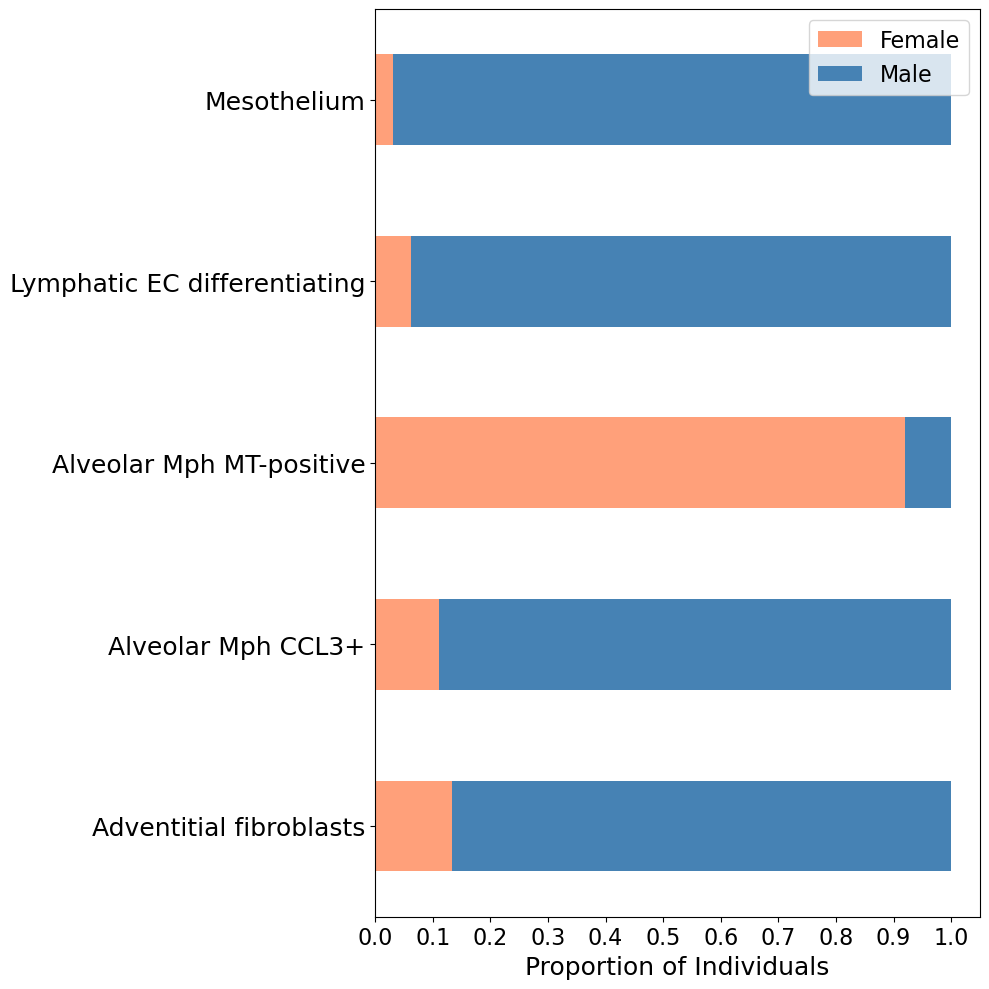

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
cell_type_df.plot(kind='barh', stacked=True, color={'female_prop': 'lightsalmon', 'male_prop': 'steelblue'}, ax=ax)

# for i, (index, row) in enumerate(cell_type_df.iterrows()):
#     ax.text(row['female_prop'] / 2, i, f"{row['female_prop']:.2f}", va='center', ha='center', color='white', fontsize=10, rotation = 90)
#     ax.text(row['female_prop'] + row['male_prop'] / 2, i, f"{row['male_prop']:.2f}", va='center', ha='center', color='white', fontsize=10, rotation = 90)


ax.set_xlabel('Proportion of Individuals', fontsize = 18)
proportions = np.round(np.linspace(0.0,1,11),1)
ax.set_xticks(proportions, proportions, fontsize = 16)
default_ticks = ax.get_yticks()
ax.set_yticks(default_ticks, cell_type_df.index, fontsize = 18)
# ax.set_ylabel('Cell Type', fontsize = 12)
# ax.set_title('Sex Distribution by Cell Type', fontsize = 16)
plt.legend(['Female', 'Male'],  loc = 'upper right', framealpha = 0.8, fontsize = 16)
plt.tight_layout()
plt.savefig(f'{path_results}Skewed_cell_types.png')